# Question 2

In [ ]:
! kaggle datasets download aslkuscu/telecust1000t

! unzip telecust1000t.zip -d /content

Dataset URL: https://www.kaggle.com/datasets/aslkuscu/telecust1000t
License(s): apache-2.0
  0% 0.00/10.3k [00:00<?, ?B/s]
100% 10.3k/10.3k [00:00<00:00, 10.0MB/s]
Archive:  telecust1000t.zip
  inflating: /content/teleCust1000t.csv  


## 1. Load the dataset

In [ ]:
import pandas as pd

# Load dataset
file_path = "teleCust1000t.csv"
data = pd.read_csv(file_path)


## 2. Analyze Feature Correlations

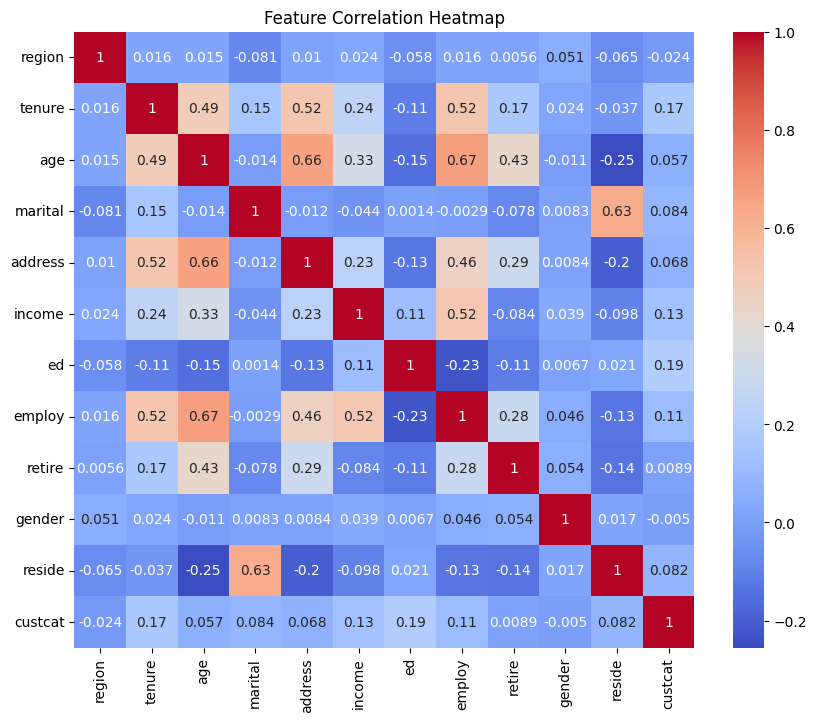

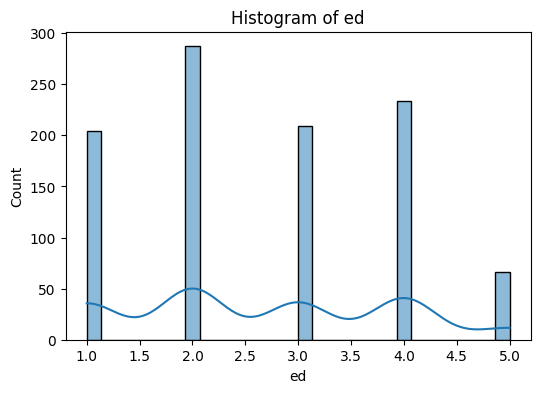

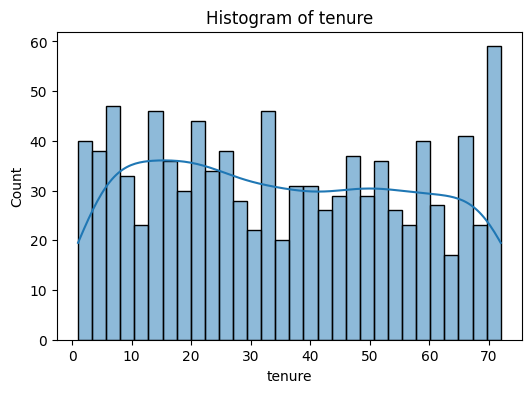

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = data.corr()

# Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Select the two most correlated features
correlated_features = corr_matrix["custcat"].abs().sort_values(ascending=False).index[1:3]

# Plot histograms
for feature in correlated_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f"Histogram of {feature}")
    plt.show()


## 3. Normalize and Split Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Separate features and target
X = data.drop(columns=['custcat']).values
y = data['custcat'].values - data['custcat'].min()

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Train-test-validation split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Convert labels to categorical format
num_classes = len(set(y))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


## 4. Define and Train MLP Networks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Enable eager execution (if needed)
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

#############################################
# 1. Define a function to build an MLP model
#############################################
def build_model(neurons, optimizer, dropout_rate=0, l2_rate=0, batch_norm=False):
    """
    Build a multi-layer perceptron (MLP) model for multi-class classification.

    Parameters:
      neurons (list): List of integers representing the number of neurons in each hidden layer.
      optimizer: Optimizer instance (e.g., SGD, Adam, RMSprop).
      dropout_rate (float): Dropout rate (0 means no dropout).
      l2_rate (float): L2 regularization factor.
      batch_norm (bool): Whether to include BatchNormalization after each Dense layer.

    Returns:
      model: A compiled Keras model.
    """
    model = Sequential()
    input_dim = X_train.shape[1]

    # Add hidden layers according to the neurons list
    for i, units in enumerate(neurons):
        if i == 0:
            model.add(Dense(units, input_dim=input_dim, kernel_regularizer=l2(l2_rate)))
        else:
            model.add(Dense(units, kernel_regularizer=l2(l2_rate)))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(Activation('relu'))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Output layer: number of neurons equals number of classes with softmax activation
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

###############################################################
# 2. Run experiments for one-layer and two-layer models separately
###############################################################
def run_pipeline(arch_name, neuron_options):
    """
    Run experiments for a given architecture.

    Parameters:
      arch_name (str): Indicates 'one_layer' or 'two_layers'
      neuron_options (list): List of neuron configurations to try.

    Returns:
      best_params (dict): A dictionary with the best hyperparameters and the final trained model.
    """
    print(f"\n========== {arch_name.upper()} MODEL EXPERIMENTS ==========")

    # Stage 1: Effect of number of neurons
    best_neurons = None
    best_val_acc = 0
    for neurons in neuron_options:
        print(f"Testing neurons configuration: {neurons}")
        optimizer = SGD(learning_rate=0.01)
        model = build_model(neurons, optimizer=optimizer,
                            dropout_rate=0, l2_rate=0, batch_norm=False)
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=50, batch_size=64, verbose=0)
        max_val = np.max(history.history['val_accuracy'])
        print(f"  -> Validation Accuracy: {max_val:.4f}")
        if max_val > best_val_acc:
            best_val_acc = max_val
            best_neurons = neurons
    print(f"Best neurons configuration: {best_neurons} with Val Acc: {best_val_acc:.4f}")

    # Stage 2: Effect of Batch Normalization
    best_bn = None
    best_val_acc_bn = 0
    for bn in [False, True]:
        print(f"Testing Batch Normalization = {bn}")
        optimizer = SGD(learning_rate=0.01)
        model = build_model(best_neurons, optimizer=optimizer,
                            dropout_rate=0, l2_rate=0, batch_norm=bn)
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=50, batch_size=64, verbose=0)
        max_val = np.max(history.history['val_accuracy'])
        print(f"  -> Validation Accuracy: {max_val:.4f}")
        if max_val > best_val_acc_bn:
            best_val_acc_bn = max_val
            best_bn = bn
    print(f"Best Batch Normalization: {best_bn} with Val Acc: {best_val_acc_bn:.4f}")

    # Stage 3: Effect of Dropout
    best_dropout = None
    best_val_acc_dropout = 0
    for dr in [0, 0.3]:
        print(f"Testing Dropout = {dr}")
        optimizer = SGD(learning_rate=0.01)
        model = build_model(best_neurons, optimizer=optimizer,
                            dropout_rate=dr, l2_rate=0, batch_norm=best_bn)
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=50, batch_size=64, verbose=0)
        max_val = np.max(history.history['val_accuracy'])
        print(f"  -> Validation Accuracy: {max_val:.4f}")
        if max_val > best_val_acc_dropout:
            best_val_acc_dropout = max_val
            best_dropout = dr
    print(f"Best Dropout: {best_dropout} with Val Acc: {best_val_acc_dropout:.4f}")

    # Stage 4: Effect of L2 Regularization
    best_l2 = None
    best_val_acc_l2 = 0
    for l2_rate in [0, 0.0001]:
        print(f"Testing L2 Regularization = {l2_rate}")
        optimizer = SGD(learning_rate=0.01)
        model = build_model(best_neurons, optimizer=optimizer,
                            dropout_rate=best_dropout, l2_rate=l2_rate, batch_norm=best_bn)
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=50, batch_size=64, verbose=0)
        max_val = np.max(history.history['val_accuracy'])
        print(f"  -> Validation Accuracy: {max_val:.4f}")
        if max_val > best_val_acc_l2:
            best_val_acc_l2 = max_val
            best_l2 = l2_rate
    print(f"Best L2 Regularization: {best_l2} with Val Acc: {best_val_acc_l2:.4f}")

    # Stage 5: Effect of Optimizer (comparing SGD, Adam, RMSprop)
    best_optimizer_name = "SGD"  # default
    best_val_acc_opt = best_val_acc_l2
    for opt_name in ["SGD", "Adam", "RMSprop"]:
        print(f"Testing Optimizer: {opt_name}")
        if opt_name == "SGD":
            optimizer = SGD(learning_rate=0.01)
        elif opt_name == "Adam":
            optimizer = Adam(learning_rate=0.001)
        elif opt_name == "RMSprop":
            optimizer = RMSprop(learning_rate=0.001)
        model = build_model(best_neurons, optimizer=optimizer,
                            dropout_rate=best_dropout, l2_rate=best_l2, batch_norm=best_bn)
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=50, batch_size=64, verbose=0)
        max_val = np.max(history.history['val_accuracy'])
        print(f"  -> Validation Accuracy: {max_val:.4f}")
        if max_val > best_val_acc_opt:
            best_val_acc_opt = max_val
            best_optimizer_name = opt_name
    print(f"Best Optimizer: {best_optimizer_name} with Val Acc: {best_val_acc_opt:.4f}")

    # Save best hyperparameters in a dictionary
    # Create a new optimizer instance for final training based on best_optimizer_name
    if best_optimizer_name == "SGD":
        final_optimizer = SGD(learning_rate=0.01)
    elif best_optimizer_name == "Adam":
        final_optimizer = Adam(learning_rate=0.001)
    elif best_optimizer_name == "RMSprop":
        final_optimizer = RMSprop(learning_rate=0.001)

    best_params = {
        "neurons": best_neurons,
        "batch_norm": best_bn,
        "dropout": best_dropout,
        "l2": best_l2,
        "optimizer_name": best_optimizer_name,
        "optimizer": final_optimizer
    }

    # Train final best model with these hyperparameters on train and validation data
    print("Training final best model for this architecture ...")
    final_model = build_model(best_neurons, optimizer=final_optimizer,
                              dropout_rate=best_dropout, l2_rate=best_l2, batch_norm=best_bn)
    final_history = final_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                    epochs=50, batch_size=64, verbose=0)
    test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
    print(f"Final Test Accuracy for {arch_name} model: {test_acc:.4f}")

    best_params["final_model"] = final_model
    best_params["test_acc"] = test_acc
    best_params["final_history"] = final_history

    return best_params

###########################################
# Run pipeline for One-Layer Model
###########################################
# For one-layer models, try two neuron configurations: [50] and [100]
one_layer_results = run_pipeline("one_layer", neuron_options=[[50], [100]])

###########################################
# Run pipeline for Two-Layer Model
###########################################
# For two-layer models, try two configurations: [100, 50] and [150, 100]
two_layer_results = run_pipeline("two_layers", neuron_options=[[100, 50], [150, 100]])

#################################################
# 3. Evaluate Best Models on Test Set and Report 10 Samples
#################################################



========== ONE_LAYER MODEL EXPERIMENTS ==========
Testing neurons configuration: [50]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  -> Validation Accuracy: 0.3875
Testing neurons configuration: [100]
  -> Validation Accuracy: 0.4187
Best neurons configuration: [100] with Val Acc: 0.4187
Testing Batch Normalization = False
  -> Validation Accuracy: 0.3500
Testing Batch Normalization = True
  -> Validation Accuracy: 0.4563
Best Batch Normalization: True with Val Acc: 0.4563
Testing Dropout = 0
  -> Validation Accuracy: 0.4563
Testing Dropout = 0.3
  -> Validation Accuracy: 0.4250
Best Dropout: 0 with Val Acc: 0.4563
Testing L2 Regularization = 0
  -> Validation Accuracy: 0.4250
Testing L2 Regularization = 0.0001
  -> Validation Accuracy: 0.4437
Best L2 Regularization: 0.0001 with Val Acc: 0.4437
Testing Optimizer: SGD
  -> Validation Accuracy: 0.4437
Testing Optimizer: Adam
  -> Validation Accuracy: 0.4812
Testing Optimizer: RMSprop
  -> Validation Accuracy: 0.4812
Best Optimizer: Adam with Val Acc: 0.4812
Training final best model for this architecture ...
Final Test Accuracy for one_layer model: 0.3700

=========

## 5. Evaluate the Best Models

In [ ]:
def evaluate_and_report(model, model_name):
    """
    Evaluate the given model on the test set and print predictions for 10 random test samples.
    """
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n{model_name} Test Accuracy: {test_acc:.4f}")

    # Select 10 random samples from the test set
    indices = np.random.choice(X_test.shape[0], 10, replace=False)
    X_sample = X_test[indices]
    y_sample_true = np.argmax(y_test[indices], axis=1)
    y_sample_pred_prob = model.predict(X_sample)
    y_sample_pred = np.argmax(y_sample_pred_prob, axis=1)

    print(f"\nRandom 10 Test Samples - {model_name}:")
    print("Index\tPredicted\tTrue")
    for i, idx in enumerate(indices):
        print(f"{idx}\t{y_sample_pred[i]}\t\t{y_sample_true[i]}")

# Evaluate one-layer model
evaluate_and_report(one_layer_results["final_model"], "One-Layer Model")
# Evaluate two-layer model
evaluate_and_report(two_layer_results["final_model"], "Two-Layer Model")



One-Layer Model Test Accuracy: 0.3700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Random 10 Test Samples - One-Layer Model:
Index	Predicted	True
21	1		1
79	0		2
66	0		0
113	0		2
49	3		2
24	2		0
90	3		2
117	0		0
54	2		0
118	1		2

Two-Layer Model Test Accuracy: 0.3650
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Random 10 Test Samples - Two-Layer Model:
Index	Predicted	True
147	0		0
151	3		1
92	2		2
59	0		0
54	2		0
101	2		2
162	1		0
156	1		0
155	2		2
64	2		1


## 6. Ensemble Model - Averaging Predictions


========== ENSEMBLE OF THE TWO MODELS ==========
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Ensemble Test Accuracy: 0.3800

--- Analysis ---
One-Layer Model Accuracy: 0.3700
Two-Layer Model Accuracy: 0.3650
Ensemble Model Accuracy: 0.3800

The ensemble may improve performance by reducing variance and combining complementary predictions.
However, if the individual models are highly correlated, the improvement might be minimal.


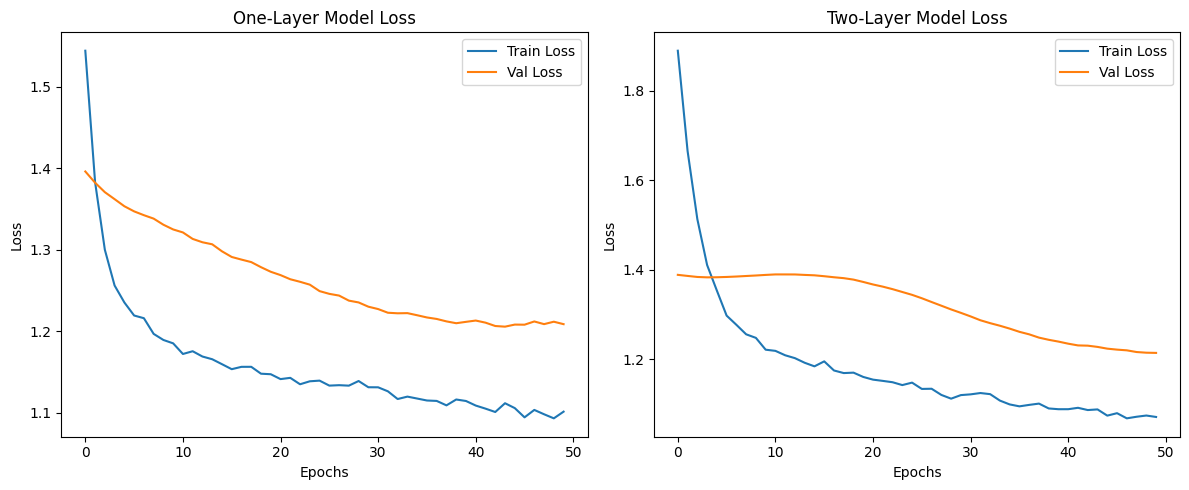

In [ ]:

#################################################
# 4. Combine (Ensemble) the Two Best Models and Evaluate
#################################################
print("\n========== ENSEMBLE OF THE TWO MODELS ==========")
# Get predicted probabilities from both models on the test set
preds_one = one_layer_results["final_model"].predict(X_test)
preds_two = two_layer_results["final_model"].predict(X_test)
ensemble_preds_prob = (preds_one + preds_two) / 2.0
ensemble_preds = np.argmax(ensemble_preds_prob, axis=1)
true_labels = np.argmax(y_test, axis=1)
ensemble_acc = np.mean(ensemble_preds == true_labels)
print(f"Ensemble Test Accuracy: {ensemble_acc:.4f}")

#################################################
# 5. Analysis Discussion
#################################################
print("\n--- Analysis ---")
print(f"One-Layer Model Accuracy: {one_layer_results['test_acc']:.4f}")
print(f"Two-Layer Model Accuracy: {two_layer_results['test_acc']:.4f}")
print(f"Ensemble Model Accuracy: {ensemble_acc:.4f}")
print("\nThe ensemble may improve performance by reducing variance and combining complementary predictions.")
print("However, if the individual models are highly correlated, the improvement might be minimal.")

#################################################
# 6. Optional: Plot loss curves for final models
#################################################
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(one_layer_results["final_history"].history['loss'], label='Train Loss')
plt.plot(one_layer_results["final_history"].history['val_loss'], label='Val Loss')
plt.title('One-Layer Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(two_layer_results["final_history"].history['loss'], label='Train Loss')
plt.plot(two_layer_results["final_history"].history['val_loss'], label='Val Loss')
plt.title('Two-Layer Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
